### Read Processed ROSY

This notebook opens an hdf5 file of processed ROSY output. The hdf5 file contains three dataframes with the following columns:

```
df_coincidences {'A_time [s]', 'A_coincidences [mV]', 'B_time [s]', 'B_coincidences [mV]', 'C_time [s]', 'C_coincidences [mV], Sum_amplitude [mV]', 'mean_timestamp [s]'}
df_amplitudes {'Channel_A_amplitudes', 'Channel_B_amplitudes', 'Channel_C_amplitudes', 'Channel_D_amplitudes'}
df_countrates {'Channel_A_countrate', 'Channel_B_countrate', 'Channel_C_countrate', 'Channel_D_countrate', 'Coincidence_countrate'}
```

This notebook also provides examples for plotting the data from these dataframes.

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py

### Read data from file

In [2]:
from pathlib import Path

FILENAME = Path("../../data/neutron_detection/processed_2025-03-18 ROSY.h5")

In [3]:
with pd.HDFStore(FILENAME) as store:
    print(store.keys())
    # Read the DataFrames using their keys
    df_coincidences = store["coincidences"]
    df_amplitudes = store["amplitudes"]
    df_countrates = store["countrates"]

['/amplitudes', '/coincidences', '/countrates']


In [4]:
df_amplitudes.head()

,Channel_A_amplitudes,Channel_B_amplitudes,Channel_C_amplitudes,Channel_D_amplitudes
0,27.774292,31.263554,52.929232,37.035249
1,27.264672,52.868449,41.532986,32.182354
2,433.941468,77.777623,30.643240,61.044307
3,27.519482,40.922213,104.338965,43.931468
4,43.062894,106.753600,58.247481,189.773724


In [5]:
df_coincidences.head()

,A_time [s],A_coincidences [mV],B_time [s],B_coincidences [mV],C_time [s],C_coincidences [mV],Sum_amplitude [mV],mean_timestamp [s]
0,1073.983941,43.062894,1073.983941,39.142987,1073.983941,30.136740,112.342620,1073.983941
1,1099.970165,72.620856,1099.970165,1383.729992,1099.970165,66.098228,1522.449076,1099.970165
2,1102.823226,31.596443,1102.823226,53.376800,1102.823226,97.754468,182.727710,1102.823226
3,1106.815829,47.139854,1106.815829,156.571946,1106.815829,72.429476,276.141276,1106.815829
4,1107.332351,32.360873,1107.332351,45.751543,1107.332351,47.357734,125.470150,1107.332351


In [6]:
mean_time = df_coincidences[["A_time [s]", "B_time [s]", "C_time [s]"]].mean()
mean_time.head()

A_time [s]    21625.801774
B_time [s]    21625.801774
C_time [s]    21625.801774
dtype: float64

In [7]:
df_countrates.tail()

,Channel_A_countrate,Channel_B_countrate,Channel_C_countrate,Channel_D_countrate,Coincidence_countrate
42678,4.0,100.0,114.0,130.0,NaN
42679,5.0,112.0,109.0,116.0,NaN
42680,4.0,100.0,98.0,118.0,NaN
42681,NaN,79.0,118.0,107.0,NaN
42682,NaN,NaN,NaN,31.0,NaN


### Plot data

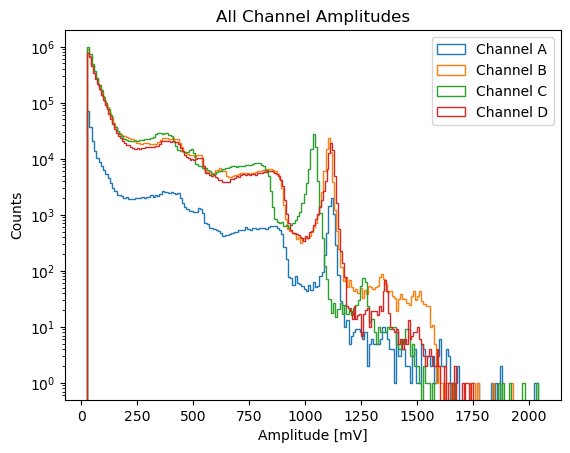

In [8]:
# Plotting amplitudes (analagous to energy, but uncalibrated)
plt.hist(
    df_amplitudes["Channel_A_amplitudes"], bins=200, histtype="step", label="Channel A"
)
plt.hist(
    df_amplitudes["Channel_B_amplitudes"], bins=200, histtype="step", label="Channel B"
)
plt.hist(
    df_amplitudes["Channel_C_amplitudes"], bins=200, histtype="step", label="Channel C"
)
plt.hist(
    df_amplitudes["Channel_D_amplitudes"], bins=200, histtype="step", label="Channel D"
)
plt.xlabel("Amplitude [mV]")
plt.ylabel("Counts")
plt.title("All Channel Amplitudes")
plt.yscale("log")
plt.legend()
plt.show()

Plotting coincidences. The separate channels show energy deposited in an individual diamond by a given
coincidence event, and the combined plot shows the total energy of a coincidence event found by
summing the energy deposited in each diamond by the particle

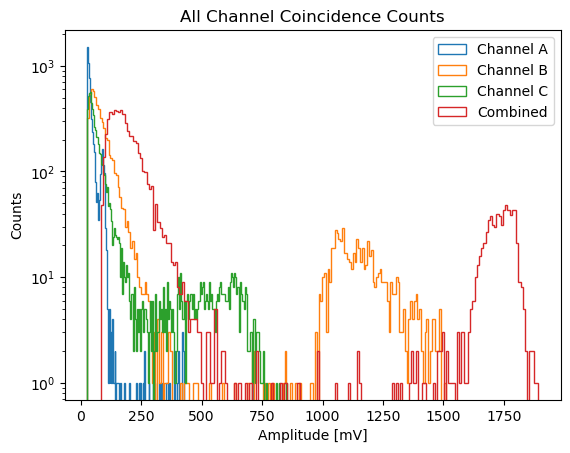

In [9]:
plt.hist(
    df_coincidences["A_coincidences [mV]"], bins=200, histtype="step", label="Channel A"
)
plt.hist(
    df_coincidences["B_coincidences [mV]"], bins=200, histtype="step", label="Channel B"
)
plt.hist(
    df_coincidences["C_coincidences [mV]"], bins=200, histtype="step", label="Channel C"
)
# Channel D is not included because it was not used to calculate coincidences (14 MeV neutrons do not reach channel D)
plt.hist(
    df_coincidences["Sum_amplitude [mV]"], bins=200, histtype="step", label="Combined"
)
plt.xlabel("Amplitude [mV]")
plt.ylabel("Counts")
plt.title("All Channel Coincidence Counts")
plt.yscale("log")
plt.legend()
plt.show()

This is how we can calculate count rates:

**Note** we shouldn't use the coincidence counts because there aren't enough of them

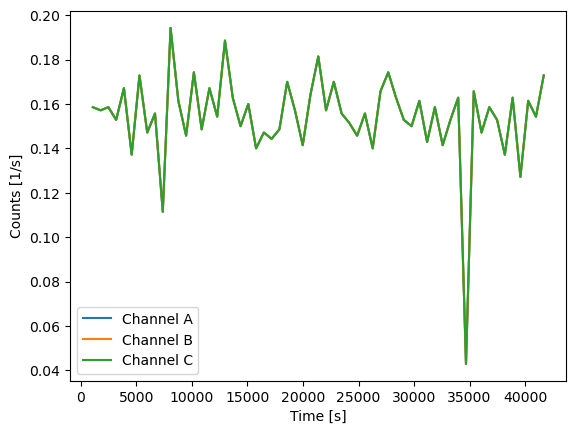

In [15]:
bin_time = 700  # seconds

def get_count_rates(bin_time: float, times: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    time_bins = np.arange(times.min(), times[-2], bin_time)
    count_rates, count_rates_bins = np.histogram(times, bins=time_bins)
    count_rates = count_rates / bin_time
    return count_rates, count_rates_bins

for channel in ["A", "B", "C"]:
    time_values = df_coincidences[f"{channel}_time [s]"].to_numpy()
    amplitudes = df_coincidences[f"{channel}_coincidences [mV]"].to_numpy()
    count_rates, count_rates_bins = get_count_rates(bin_time, time_values)


    plt.plot(count_rates_bins[:-1], count_rates, label=f"Channel {channel}")
plt.xlabel("Time [s]")
plt.ylabel("Counts [1/s]")
plt.legend()

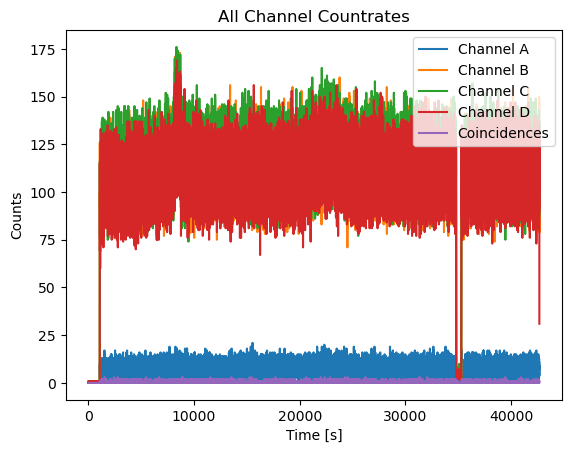

In [11]:
# Plotting countrates
plt.plot(df_countrates["Channel_A_countrate"], label="Channel A")
plt.plot(df_countrates["Channel_B_countrate"], label="Channel B")
plt.plot(df_countrates["Channel_C_countrate"], label="Channel C")
plt.plot(df_countrates["Channel_D_countrate"], label="Channel D")
plt.plot(df_countrates["Coincidence_countrate"], label="Coincidences")
plt.xlabel("Time [s]")
plt.ylabel("Counts")
plt.title("All Channel Countrates")
plt.legend()
plt.show()

In [12]:
# Defining a moving average calculation function for clearer countrate viewing
def moving_average(arr, window_size):
    return np.convolve(arr, np.ones(window_size) / window_size, mode="valid")

In [13]:
# Calculate all average countrates
window = 500
avg_Channel_A_countrate = moving_average(df_countrates["Channel_A_countrate"], window)
avg_Channel_B_countrate = moving_average(df_countrates["Channel_B_countrate"], window)
avg_Channel_C_countrate = moving_average(df_countrates["Channel_C_countrate"], window)
avg_Channel_D_countrate = moving_average(df_countrates["Channel_D_countrate"], window)
avg_Coincidence_countrate = moving_average(
    df_countrates["Coincidence_countrate"], window
)

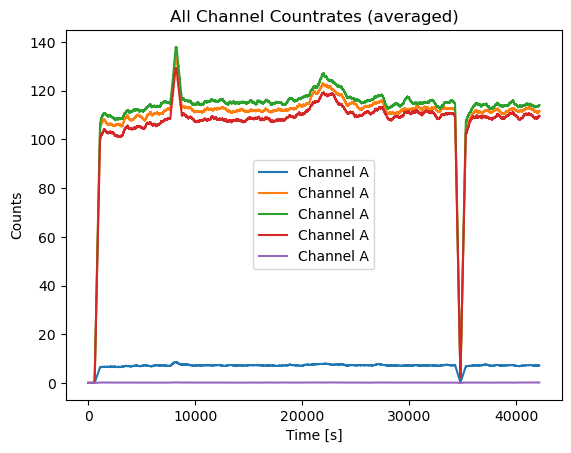

In [14]:
# Note that peaks and dips will probably be broadened, as the averaging window may span across the peak/dip
# A smaller window can correct this, but will give a fuzzier plot
plt.plot(avg_Channel_A_countrate, label="Channel A")
plt.plot(avg_Channel_B_countrate, label="Channel A")
plt.plot(avg_Channel_C_countrate, label="Channel A")
plt.plot(avg_Channel_D_countrate, label="Channel A")
plt.plot(avg_Coincidence_countrate, label="Channel A")
plt.xlabel("Time [s]")
plt.ylabel("Counts")
plt.title("All Channel Countrates (averaged)")
plt.legend()
plt.show()